# made some changes change in environment:
add statsmodels, seaborn  to pip install 


1. [x] Introduction about the dynamic foraging task (Jeremiah just has half an hour lecture so maybe we need some explanation or some figures to explain the mechanism) [Shuchen]
2. [x] Introduction about generative model, [x] R-W rule [ ] winstayloseshift[Shuchen], and how this code simulates data
3. [x] Why and how to perform model simulation [Shuchen]
4. [x] How to perform model fitting and parameter recovery [Shuchen]
5. [] make things more coherent, check what else would be needed
6. [x] getting more parameter recovery plots, to make the process more intuitive?
7. [] I do not understand how the simple win-stay-lose-shift translate to Han's code
    - I THINK the code could only implement a non-noisy WSLS model [Yusi]
8. [x] Let's show a parameter recovery plot for RW1972 
9. [x] And also a model comparison plot between a number of models
10/. [] clean up some code in the util function
11. [] add explanations of the code class [Yusi]
12. [] Do we nned to combine env./agent simulation code with the text explanation at the beginning? [Yusi]
13. [] add exercise problems [Yusi]


<img src="./resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">DAY 3 Workshop SWDB 2025 </h1> 
<h3 align="center">Wednesday, August 27th, 2025</h3> 
<h3 align="center">Fiting Models on Behavioral Data</h3> 

Behavioral data typically consist of choices, Reaction times, Eye movements, and sometimes Neural signals. Computational models instantiate algorithmic hypotheses about the processes that generate behavior. Fitting computational models to behavioral data allows us to probe the algorithms underlying behavior and test mechanistic hypotheses about the mind. Thereby, we can use precise mathematical models to make sense of rich behavioral data.


Model fitting is a powerful tool for making cognitive theories explicit, testable, and quantitatively precise. It typically involves:

1. **Simulation** – to understand what the model predicts.
2. **Parameter estimation** – to fit the model to data.
3. **Model comparison** – to evaluate competing hypotheses.



__Objectives of this tutorial__
    
-understand computational algorithms governing observed behavior

-recover these algorithms by model fitting and model comparison

-identify computational algorithms used by mice in the Dynamic Foraging task




---

## Model 1: Rescorla-Wagner

We introduce **Q-learning**, a reinforcement learning model that estimates the expected value of each action and updates those estimates based on **reward prediction errors** (RPEs) (Bertsekas & Tsitsiklis, 1996; Sutton & Barto, 1998). This model captures how action values are incrementally adjusted over time and allows us to compute trial-by-trial RPEs. A classic model of such learning is the **Rescorla-Wagner rule** (Rescorla & Wagner, 1972). In this model, the expected value of each action is updated based on the discrepancy between received and expected outcomes. Specifically, the value of option $k$ on trial $t$, denoted $Q^k_t$, is updated according to:

$$
Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t)
$$

Here:
- $r_t$ is the reward on trial $t$,
- $\alpha \in [0, 1]$ is the **learning rate**, controlling how strongly the prediction error $(r_t - Q^k_t)$ updates the value,
- $Q^k_0$ is typically initialized to zero or treated as a free parameter.

To translate learned values into choices, we use the **softmax decision rule**, which models the stochastic selection of actions based on their values. The probability of choosing action $k$ is given by:

$$
p^k_t = \frac{\exp(\beta Q^k_t)}{\sum_{i=1}^K \exp(\beta Q^i_t)}
$$

Here:
- $\beta$ is the **inverse temperature** parameter. Higher $\beta$ leads to more deterministic (greedy) choices, while lower $\beta$ encourages more exploratory behavior.


By combining the learning rule and decision rule, we obtain a simple yet powerful model of behavior with **two free parameters**: the learning rate $\alpha$ and the inverse temperature $\beta$. In our general notation, the model is parameterized by:

$$
\boldsymbol{\theta}_3 = (\alpha, \beta)
$$


---

## Model 2: Win-Stay Lose-Shift

The **Win-Stay Lose-Shift (WSLS)** strategy is a simple, psychologically plausible decision-making rule that does not rely on estimating action values. Instead, it operates directly on the outcome of the previous trial.

The idea is straightforward:
- If the agent **received a reward** for choosing an action on the previous trial (a **win**), it **repeats** that action.
- If the agent **did not receive a reward** (a **loss**), it **switches** to the alternative action on the next trial.

We can express this as a probabilistic rule using two parameters:
- $p_{\text{stay}|\text{win}}$: the probability of staying with the same choice after a win,
- $p_{\text{shift}|\text{loss}}$: the probability of switching after a loss.

Let $c_{t-1}$ denote the action chosen on the previous trial, and $r_{t-1} \in \{0, 1\}$ be the reward received. Then, the probability of choosing action $k$ on trial $t$ is:

$$
p^k_t = 
\begin{cases}
p_{\text{stay}|\text{win}}, & \text{if } c_{t-1} = k \text{ and } r_{t-1} = 1 \\
1 - p_{\text{shift}|\text{loss}}, & \text{if } c_{t-1} = k \text{ and } r_{t-1} = 0 \\
1 - p_{\text{stay}|\text{win}}, & \text{if } c_{t-1} \neq k \text{ and } r_{t-1} = 1 \\
p_{\text{shift}|\text{loss}}, & \text{if } c_{t-1} \neq k \text{ and } r_{t-1} = 0 \\
\end{cases}
$$

This rule defines a **reactive strategy** that bases choices solely on the most recent outcome. It is memoryless and value-free, making it distinct from reinforcement learning models like Rescorla-Wagner or Q-learning.


The WSLS model has two free parameters: the probability of repeating after a win ($p_{\text{stay}|\text{win}}$) and the probability of switching after a loss ($p_{\text{shift}|\text{loss}}$). In our general notation, the model is parameterized by:

$$
\boldsymbol{\theta}_4 = \left(p_{\text{stay}|\text{win}},\; p_{\text{shift}|\text{loss}} \right)
$$



In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import UncoupledBlockTask
from utils_model_recovery import *
import multiprocessing as mp
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Refresh: The Dynamic Foraging Task

From flies to primates, all animals must learn about their environment, search for resources, and make adaptive decisions. Foraging—the process of selecting actions to obtain rewards—is a behavior conserved across a wide range of species.

The **dynamic foraging task** provides a simple paradigm for studying this behavior. In this task, a head-fixed mouse hears a "go cue" signaling the opportunity to perform one of two possible actions: **licking left** or **licking right**.

Unbeknownst to the animal, the **probability of receiving a water reward** for licking left or right fluctuates over time. Thus, the animal must learn to infer which action is more rewarding under changing contingencies.

### Environment initialization
First we want to initialize a world environment which will interact with the agent to give feedback, including reward/force switch etc. This is like the rules for the task. The `UncoupledBlockTask` is a wrapped environment where reward probabilities for each action (e.g., left or right) change **independently** across blocks of trials.

<details>
<summary><b> Class UncoupledBlockTask explained </b></summary>

**Overview**

- The `UncoupledBlockTask` class implements a dynamic foraging environment where reward probabilities for left and right choices change **independently** across blocks of trials.

**Initialization Arguments**
- `reward_baiting`: `bool = False`
  - Whether rewards persist until collected
  - `True`: Uncollected rewards remain available
  - `False`: Rewards are generated fresh each trial

- `allow_ignore`: `bool = False`
  - Whether agent can skip trials
  - `True`: Adds "ignore" as third action option
  - `False`: Agent must choose left or right

- `num_arms`: `int = 2`
  - Number of choice options (typically 2 for left/right)

- `num_trials`: `int = 1000`
  - Total number of trials in the session

- `seed`: `int = None`
  - Random seed for reproducibility

- `rwd_prob_array`: `List[float] = [0.1, 0.5, 0.9]`
  - Available reward probabilities for block assignment
  - Each new block randomly selects from this array

- `block_min`: `int = 20`
  - Minimum block length in trials

- `block_max`: `int = 35`
  - Maximum block length in trials

- `persev_add`: `bool = True`
  - Enable anti-perseveration mechanism

- `perseverative_limit`: `int = 4`
  - Number of consecutive choices on min-prob side to trigger anti-persev

- `max_block_tally`: `int = 4`
  - Maximum consecutive blocks one side can be better before forced balancing

**Key Methods**

- `reset()`: Initialize new session with fresh block schedule
- `step(action)`: Execute one trial and return (observation, reward, done, info)
- `generate_new_trial()`: Create reward probabilities for next trial
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data
- `get_p_reward()`: Get reward probability matrix for analysis
- `plot_reward_schedule()`: Visualize block structure and choice patterns


</details>

In [34]:
task = UncoupledBlockTask(reward_baiting=True, num_trials=100, seed=42)

# Simulation: Agent Interacting with the Task Environment

Once you have an experimental design and a set of computational models, a really important step is to create fake, or surrogate data (Palminteri et al., 2017). That is, you should use the models to simulate the behavior of participants in the experiment, and to observe how behavior changes with different models, different model parameters, and different variants of the experiment. 

Simulation involves running an artificial agent — here, performing the dynamic foraging task — with specified parameters to generate synthetic behavioral data. These surrogate datasets can be analyzed like real data to visualize expected behavior under different assumptions, evaluate the impact of model parameters, test experimental design sensitivity, and generate falsifiable predictions.

Examples: Cohen et al., 1990; Rescorla & Wagner, 1972; Collins & Frank, 2014; Farashahi et al., 2017; Montague et al., 1996; Lee & Webb, 2005.

### Agent initialization

Next we want to initialize an agent which will interact with the task environment following its internal algorithm such as Q-learning. `ForagerQLearning` is a sophisticated reinforcement learning agent that implements Q-learning for dynamic foraging tasks. 


<details>
<summary><b> class ForagerQLearning explained </b></summary>

**Overview:**

The `ForagerQLearning` class is a flexible reinforcement learning agent that incrementally updates action-value estimates (Q-values) based on reward history, supports different learning rates/forget rates for rewarded versus unrewarded outcomes, and can incorporate choice history effects through choice kernels. 

**Initialization configs:**
- `number_of_learning_rate`: `Literal[1, 2] = 2`
  - Controls learning rate structure
  - `1`: Single learning rate for all outcomes
  - `2`: Separate rates for rewarded (`learn_rate_rew`) and unrewarded (`learn_rate_unrew`) outcomes

- `number_of_forget_rate`: `Literal[0, 1] = 1`
  - Controls forgetting mechanism
  - `0`: No forgetting of unchosen options
  - `1`: Includes `forget_rate_unchosen` parameter

- `choice_kernel`: `Literal["none", "one_step", "full"] = "none"`
  - Choice history influence on decisions
  - `"none"`: No choice history effects
  - `"one_step"`: Only immediate previous choice (Bari2019 style)
  - `"full"`: Exponentially weighted choice history with learnable parameters

- `action_selection`: `Literal["softmax", "epsilon-greedy"] = "softmax"`
  - Decision strategy
  - `"softmax"`: Probabilistic selection with inverse temperature parameter
  - `"epsilon-greedy"`: Exploration with fixed epsilon probability

- `params`: `dict = {}`
  - Initial model parameters (auto-generated based on configuration)
  - Learning rates: `learn_rate`, `learn_rate_rew`, `learn_rate_unrew` (0.0-1.0)
  - Forget rates: `forget_rate_unchosen` (0.0-1.0)
  - Bias: `biasL` (left side bias, -5.0 to 5.0)
  - Action selection: `softmax_inverse_temperature` (0.0-100.0) or `epsilon` (0.0-1.0)
  - Choice kernel: `choice_kernel_relative_weight`, `choice_kernel_step_size` (0.0-1.0)

- `**kwargs`: Additional arguments passed to base class (e.g., `seed` for reproducibility)

**Key Methods:**

- `perform(task)`: Simulate agent behavior on a foraging task
- `fit(choice_history, reward_history)`: Fit model parameters to behavioral data
- `act(observation)`: Select action based on current Q-values
- `learn(observation, action, reward, next_observation, done)`: Update Q-values after action
- `plot_session()`: Visualize behavioral session and internal states
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data

</details>

In [35]:
forager = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=0,choice_kernel="none",action_selection="epsilon-greedy")

**Exercise**: describe this Q-learning model

1. How is the learning rate going to be updated? Same for all choices or differentiate between rewarded and unrewarded choices?
2. What is the forget mechanism? 
3. Is previous choice going to influece the choice structure? 
4. What is the decision strategy? 
5. What are the parameters associated? 

<details>
<summary><b> Answer </b></summary>

1. Same learning rate for all choices
2. No forgetting mechanism
3. No choice kernel
4. Epsilon-greedy decision strategy
5. Parameters: `forager.params`



In [36]:
# Simulate the model
forager.perform(task)

In [38]:
# obtain behaviorial data from the forager
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value
print("Ground Truth Parameters:", ground_truth_params)
# Get the history
choice_history = forager.get_choice_history() # 0: Left, 1: Right
reward_history = forager.get_reward_history() # 0: Unrewarded, 1: Rewarded
p_reward = forager.task.get_p_reward() # row 0: Left, row 1: Right


Ground Truth Parameters: {'learn_rate': 0.5, 'biasL': 0.0, 'epsilon': 0.1}


#### Visualization of reward probability of two arms in the task

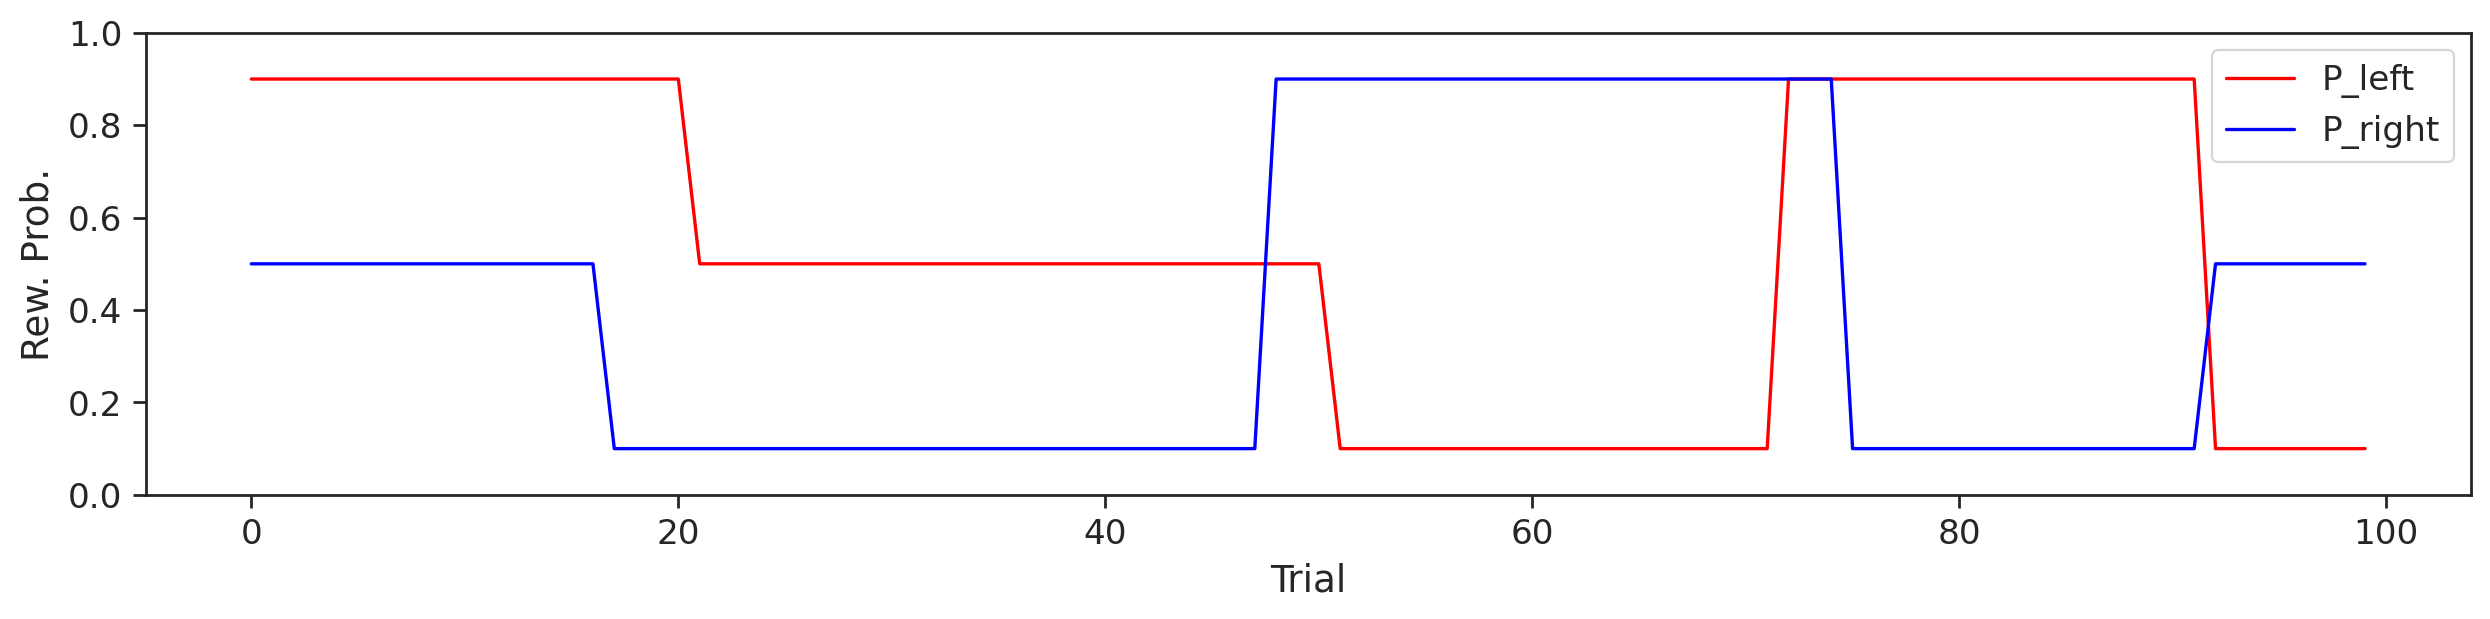

In [40]:
# reward probabilities fluctuate over trials between [0.1, 0.5, 0.9]
# print(np.unique(p_reward))
# visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)
ax.plot(task.get_p_reward()[0], label='P_left', color='red')
ax.plot(task.get_p_reward()[1], label='P_right', color='blue')
ax.set_ylim(0, 1)
ax.set_xlabel('Trial')
ax.set_ylabel('Rew. Prob.')
ax.legend()

#### Visualization choices by the simulated agent

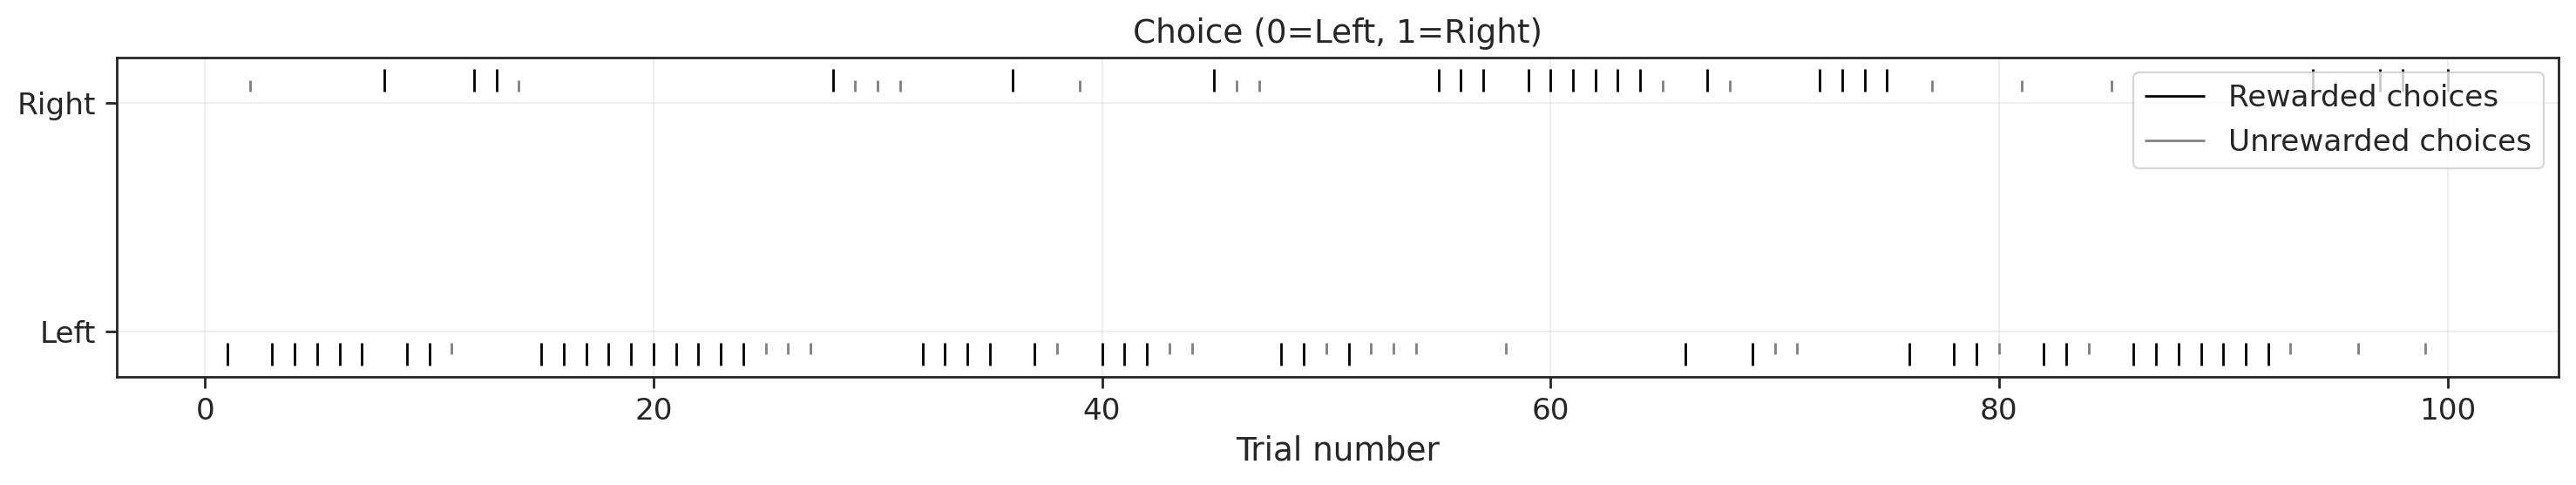

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)

rewarded_trials = reward_history == 1
unrewarded_trials = reward_history == 0
xx = np.nonzero(rewarded_trials)[0] + 1
yy_temp = choice_history[rewarded_trials]
yy_right = yy_temp[yy_temp > 0.5] + 0.05
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5] - 0.05
xx_left = xx[yy_temp < 0.5]

# Rewarded choices
ax.vlines(xx_right, yy_right, yy_right + 0.1, alpha=1, linewidth=1, color="black", label="Rewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left, alpha=1, linewidth=1, color="black")

unrewarded_trials = reward_history == 0
xx = np.nonzero(unrewarded_trials)[0] + 1
yy_temp = choice_history[unrewarded_trials]
yy_right = yy_temp[yy_temp > 0.5]
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5]
xx_left = xx[yy_temp < 0.5]

# Unrewarded choices
ax.vlines(xx_right, yy_right + 0.05, yy_right + 0.1, alpha=1, linewidth=1, color="gray", label="Unrewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left - 0.05, alpha=1, linewidth=1, color="gray")

# Set up axis labels and limits
ax.set_xlabel('Trial number')
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Left', 'Right'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.title('Choice (0=Left, 1=Right)')
plt.tight_layout()
plt.show()

#### Visualization of choice statistics
1. Base reward probabilities = p_right / (p_right + p_left)
2. Choice = moving average of choice history, i.e. moving average of choosing right 
3. Q(L) (`ground_truth_q_value[0,:]`): ground truth q value for left choice
4. Q(R) (`ground_truth_q_value[1,:]`): ground truth q value for right choice
5. choice_prob(R/R+L) (`ground_truth_choice_prob[1] / ground_truth_choice_prob.sum(axis=0)`): choice probability normalized

??? What is ground truth Q value here?

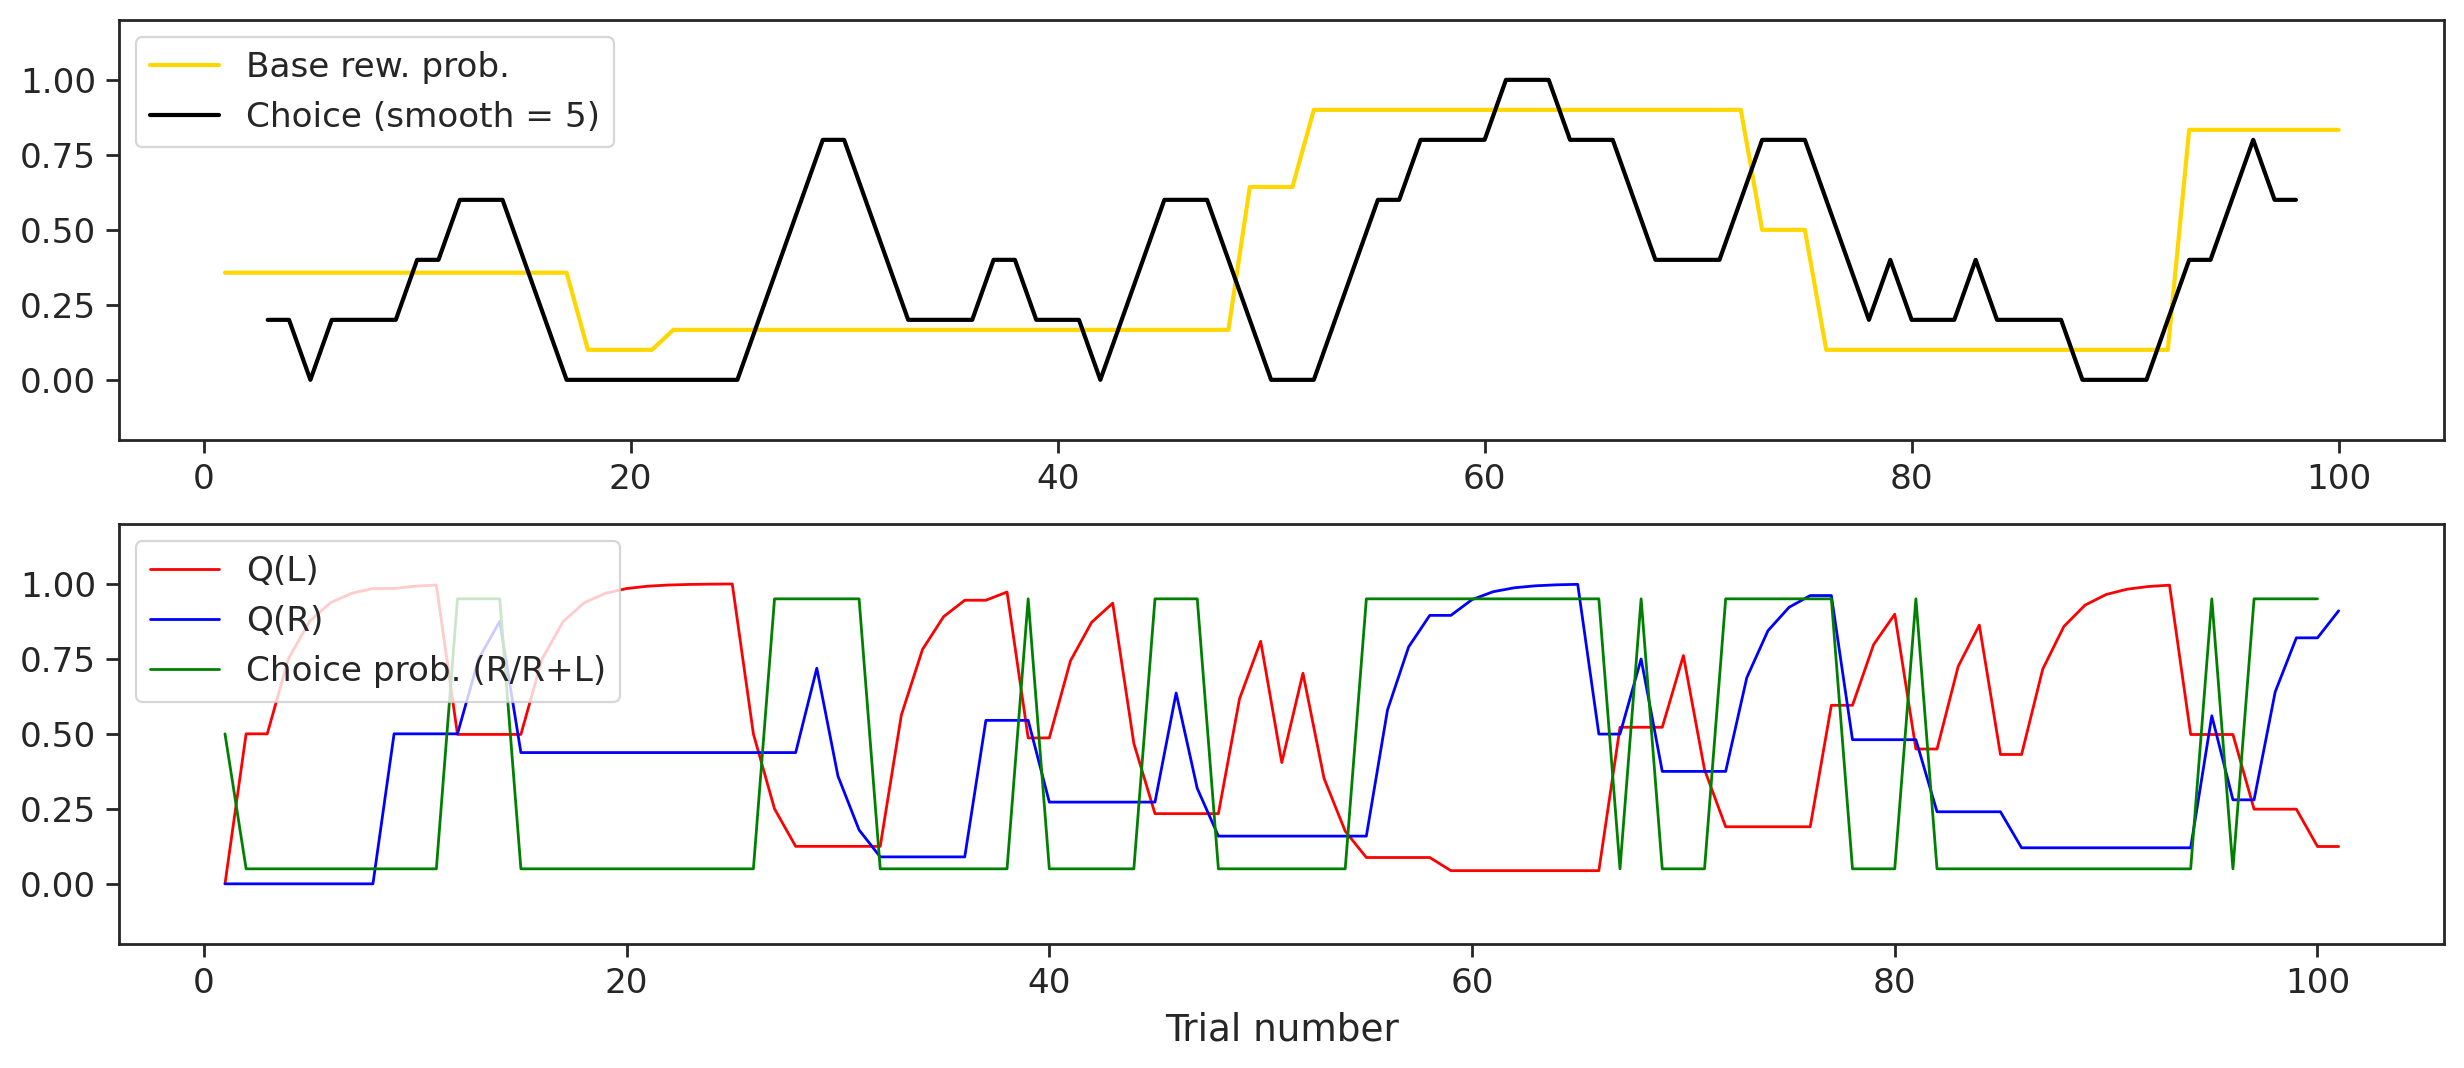

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), dpi=200)

def moving_average(a, n=3):
    """Compute moving average of a list or array."""
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n - 1):] / n

n_trials = len(choice_history)
smooth_factor = 5  

ax = axs[0]
ax.plot(np.arange(1,n_trials+1), p_reward[1, :] / (np.sum(p_reward, axis=0)),
         color="gold",label="Base rew. prob.",lw=1.5,)
y = moving_average(choice_history, n=smooth_factor)
ax.plot(np.arange(0, len(y)) + int(smooth_factor / 2) + 1, y,
        linewidth=1.5,color="black",label="Choice (smooth = %g)" % smooth_factor)
ax = axs[1]
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[0, :], lw=1, color="red", ls="-", label="Q(L)")
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[1, :], lw=1, color="blue", ls="-", label="Q(R)")
ax.plot(np.arange(1,n_trials+1), ground_truth_choice_prob[1] / np.sum(ground_truth_choice_prob, axis=0), lw=1, color="green", ls="-", label="Choice prob. (R/R+L)")

axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('Trial number')
axs[0].set_ylim(-0.2, 1.2)
axs[1].set_ylim(-0.2, 1.2)
plt.show()

Question: why are Q values fluctuctuating?

<details>
<summary><b> Answer </b></summary>
Baiting trials!
</details>

??? I didn't get what does the baiting trials mean?

#### Visualization on one plot

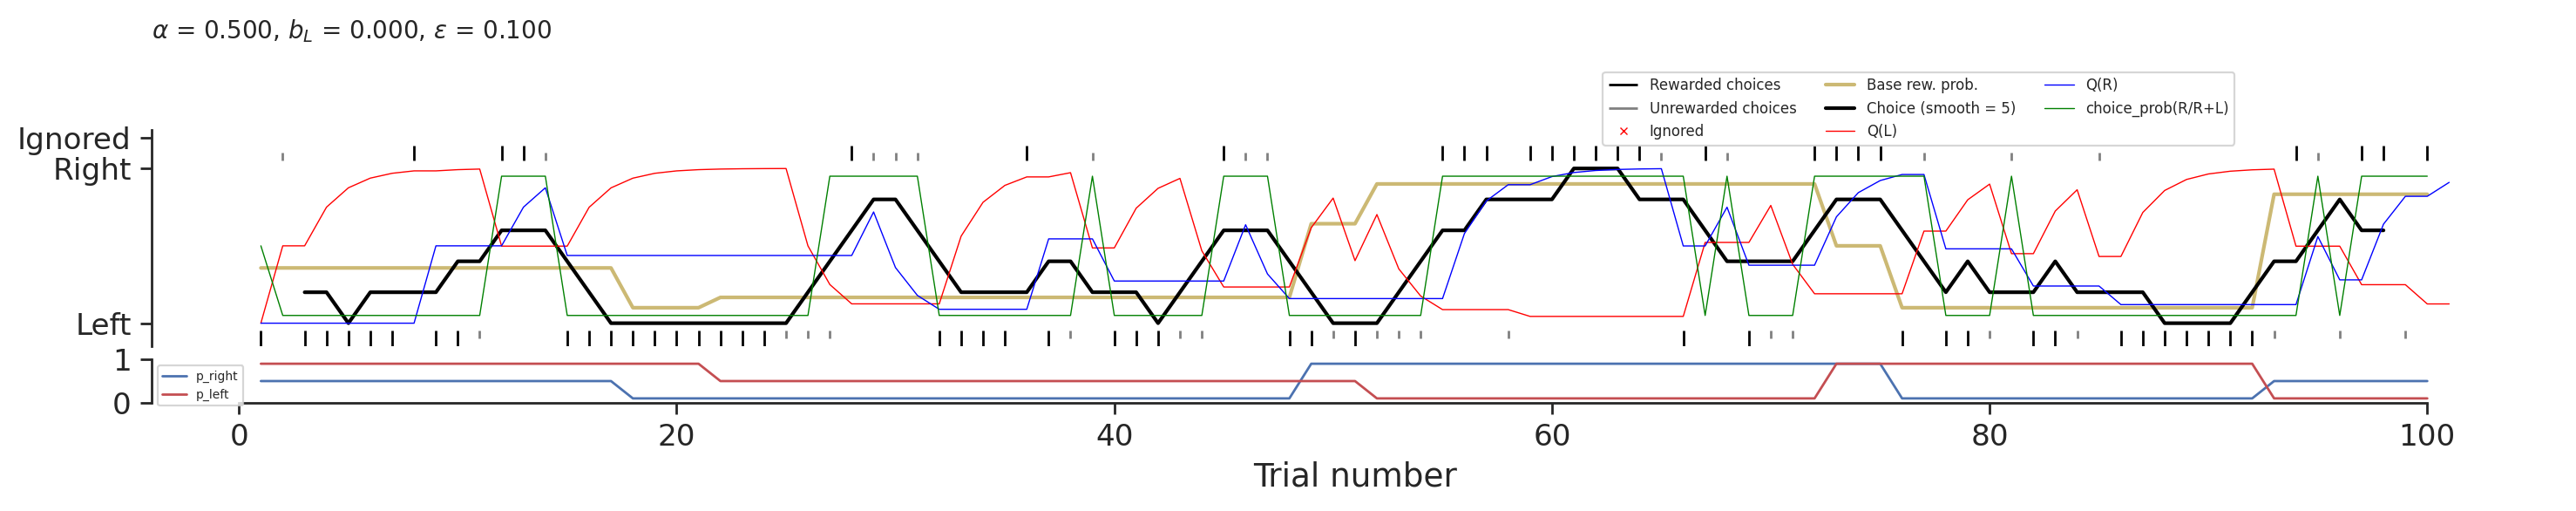

In [44]:
fig, axes = forager.plot_session(if_plot_latent=True)

## Parameter Recovery
Parameter estimation refers to **inferring model parameters** that best explain observed behavior.
Parameters are typically inferred using **maximum likelihood** or **Bayesian methods**.

> **Examples:** Ratcliff, 1978; Wilson et al., 2013; Daw et al., 2011; Frank et al., 2007; Donkin et al., 2016; Gillan et al., 2016.



## Basic Idea of Model Fitting


The observed data  $d_{1:T}$ includes:
- **Choice history**: $c_t \in \{\text{L}, \text{R}\}$
- **Reward history**: rewards associated with left and right actions:
  - $r_{R,t}$: reward received when choosing right at time $t$
  - $r_{L,t}$: reward received when choosing left at time $t$


### Maximum Likelihood Estimate

To fit a model to behavioral data, we estimate the parameters $\boldsymbol{\theta}_M$ that maximize the likelihood of the observed data under model $M$. This is typically done using **maximum likelihood estimation (MLE)**:

$$
\hat{\boldsymbol{\theta}}^{\text{MLE}}_M = \arg\max_{\boldsymbol{\theta}_M} \log p(d_{1:T} \mid \boldsymbol{\theta}_M, M) = \arg\max_{\boldsymbol{\theta}_M} \sum_{t=1}^{T} \log p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}_M, M)
$$

---

### Predictive Likelihood

At each time step $t$, you may use the model $M$ with parameters $\boldsymbol{\theta}_M$ uses the full **history up to $t - 1$**, i.e., $d_{1:t-1}$, to compute the likelihood of the next choice $c_t$:

$$
L_t = p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}_M, M)
$$

This likelihood score (e.g., 0.63) reflects how well the model predicts the observed choice on trial $t$.

🟥 **Important**: This is a **predictive** model fit — it evaluates how well the model predicts observed behavior. It is **not generative**, i.e., we do not simulate new behavior forward in time.



Now we have access to the simulated agent's choices and environment feedback. How can we obtain the agent's parameter, which govern its choices from Q-learing model? We could utilize the `fit` function associated with `forager` class. 

<details>
<summary><b> forager.fit() explained </b></summary>

**Main purpose** 

Finds the model parameters that maximize the likelihood of observing the actual choice and reward history. Computes model evaluation metrics (AIC, BIC, prediction accuracy). Optionally cross-validation.

**Inputs** 
- `fit_choice_history` / `fit_reward_history`: Behavioral data to fit
- `clamp_params`: Fix specific parameters (e.g., `{"biasL": 0}`)
- `fit_bounds_override`: Custom parameter bounds for fitting
- `k_fold_cross_validation`: Number of CV folds (None = no CV)
- `DE_kwargs`: Optimization settings (workers, seed, etc.)

**Outputs**
- `fitting_result`: Best parameters, likelihood, AIC/BIC, prediction accuracy
- `fitting_result_cross_validaiton` (if requested): Test accuracies across folds


</details>


In [45]:
forager.fit(
    choice_history,
    reward_history,
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2025-08-10 00:01:33,770 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
2025-08-10 00:01:33,770 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
2025-08-10 00:01:33,770 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
2025-08-10 00:01:33,770 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
2025-08-10 00:01:33,770 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 35.22915924721766
differential_evolution step 2: f(x)= 35.22757307245893
differential_evolution step 3: f(x)= 35.22757307245893
differential_evolution step 4: f(x)= 35.22757307245893
differential_evolution step 5: f(x)= 35.22757307245893
differential_evolution step 6: f(x)= 35.22757307245893
differential_evolution step 7: f(x)= 35.22757307245893
differential_evolution step 8: f(x)= 35.22757307245893
Polishing solution with 'L-BFGS-B'


In [46]:
# Check fitting performance and results
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 100
Fitted parameters: ['learn_rate', 'epsilon']
Ground truth: ['0.5000', '0.1000']
Fitted:       ['0.5141', '0.2222']
Likelihood-Per-Trial: 0.7030865730885499
Prediction accuracy full dataset: 0.89



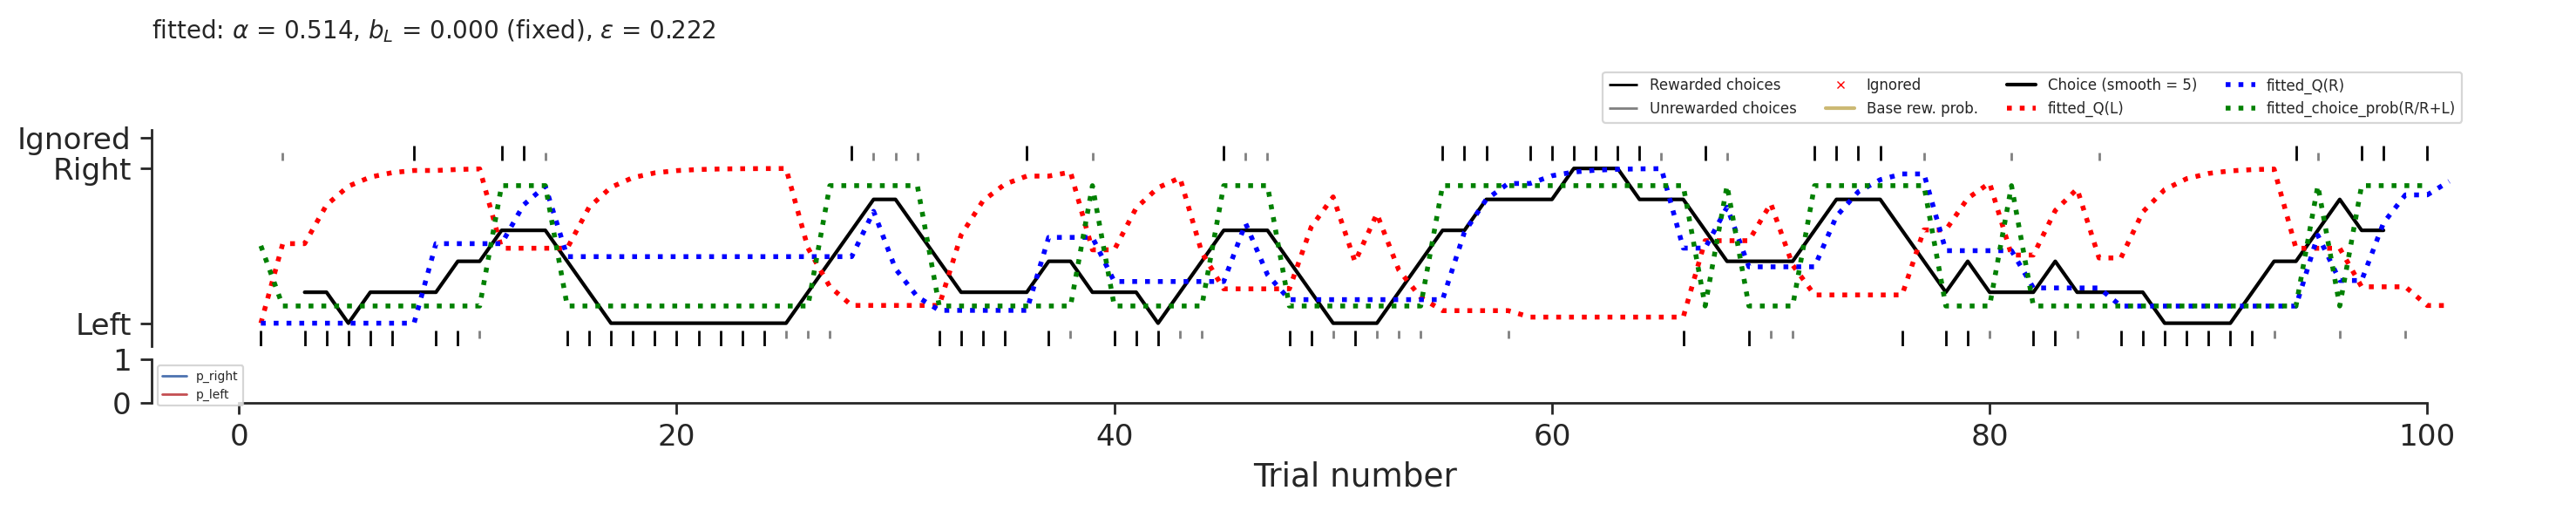

In [47]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

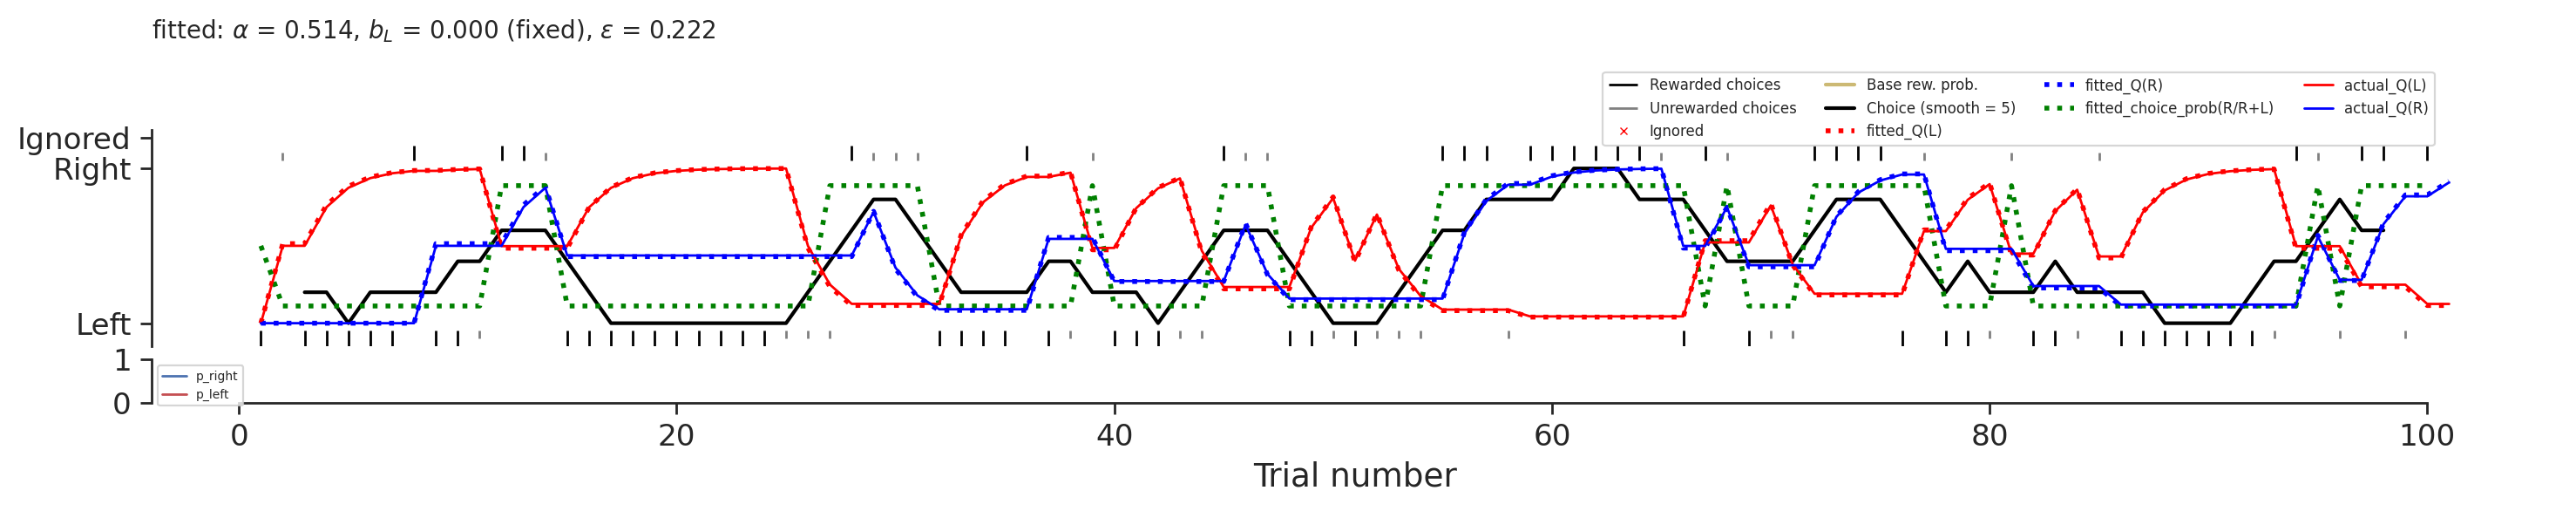

In [48]:
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)
xx = np.arange(1, len(ground_truth_q_value[0]) + 1)
axes[0].plot(xx, ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(xx, ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

**Question**: Why the inferred learning rate/epsilon don't match ground truth but the fitted latent variables still look the same? 

## Another example: win-stay-lose-shift


The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions.

In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1−\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case, the probability of choosing option k is: 

Let $c_t \in \{1, 2\}$ be the choice at trial $t$, and $r_t \in \{0, 1\}$ the reward at trial $t$. Then:

$$
p_k^t = 
\begin{cases}
1 - \frac{\epsilon}{2} & \text{if } (c_{t-1} = k \land r_{t-1} = 1) \text{ or } (c_{t-1} \neq  k \land r_{t-1} = 0) \\
\frac{\epsilon}{2} & \text{if } (c_{t-1} \not = k \land r_{t-1} = 1) \text{ or } (c_{t-1} = k \land r_{t-1} = 0)
\end{cases}
$$

Although more complex to implement, this model still only has one free parameter, the overall level of randomness, $ \theta_2 = \epsilon $.

**Question:**

Why is the probability $1-\frac{\epsilon}{2}$?

<details>
<summary><b> Answer </b></summary>

- On each trial, the agent applies the win-stay-lose-shift rule with probability $1-\epsilon$.
    - If applying the rule:  
        - **Win (rewarded):** repeat previous choice  
        - **Loss (unrewarded):** switch to the other choice  
- With probability $\epsilon$, the agent ignores the rule and chooses randomly:
    - Each option has probability $0.5$.

**List all outcomes:**

| Previous Choice | Previous Reward | Probability of Choosing $k$ at $t$ |
|-----------------|----------------|------------------------------------|
| $c_{t-1} = k$   | $r_{t-1} = 1$  | $1-\epsilon + \frac{\epsilon}{2}$  |
| $c_{t-1} = k$   | $r_{t-1} = 0$  | $\frac{\epsilon}{2}$               |
| $c_{t-1} \neq k$| $r_{t-1} = 1$  | $\frac{\epsilon}{2}$               |
| $c_{t-1} \neq k$| $r_{t-1} = 0$  | $1-\epsilon + \frac{\epsilon}{2}$  |



</details>

Now let's initialize an artificial agent with noisy 'win-stay-lose-shift' algorithm with `ForagerLossCounting` class

<details>
<summary><b> class ForagerLossCounting explained </b></summary>

**Overview:**

The `ForagerLossCounting` class implements a simple, psychologically plausible agent that uses a loss-counting strategy to decide when to switch actions in a dynamic foraging task. Instead of tracking action values, the agent counts consecutive unrewarded trials (losses) for the current choice. When the loss count exceeds a threshold, the agent switches to the other option.

**Inputs**
- `win_stay_lose_switch`: Boolean, enables classic win-stay-lose-shift logic (default True). If true, `loss_count_threshold_mean` and `loss_count_threshold_std` are fixed at 1 and 0
- `choice_kernel`: String, controls influence of choice history ("none", "one_step", "full").
- `params`: dictionary with following keys
    - `loss_count_threshold_mean`: Mean threshold for switching after losses.
    - `loss_count_threshold_std`: Standard deviation for threshold (adds stochasticity).
    - `biasL`: Optional bias toward left choice.

**Unique Attributes**
- `loss_count`: number of consecutive unrewarded trials

</details>

I THINK this is a not noisy WSLS model

In [ ]:
# initialize the task
task = UncoupledBlockTask(reward_baiting=True, num_trials=100, seed=42)
# initialize the forager with noisy 'win-stay-lose-shift' algorithm
forager = ForagerLossCounting(win_stay_lose_switch=True, choice_kernel='none')
# fix some parameters
# forager.set_params(biasL=0.1)  
# extract the parameters
forager.params.model_dump() # biasL term is not used here


In [19]:
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_loss_count = forager.loss_count
ground_truth_choice_prob = forager.choice_prob

# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()


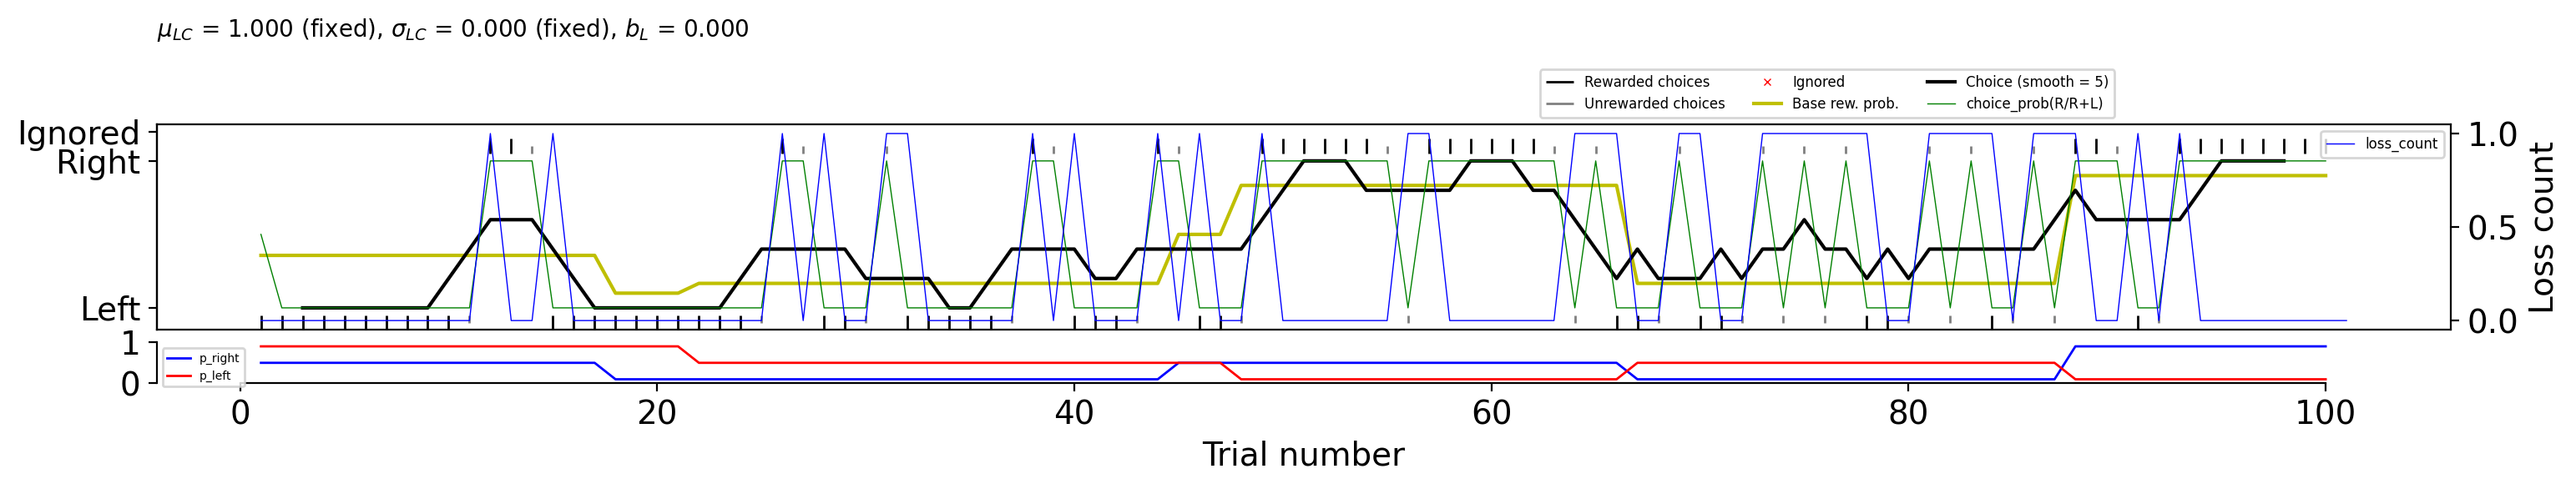

In [20]:
# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

Notice the `loss_count` trace

In [21]:
# Fit the model to recover parameters
forager.fit(
    choice_history,
    reward_history,
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2025-08-09 19:14:42,075 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
2025-08-09 19:14:42,075 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
2025-08-09 19:14:42,075 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 1.3873313149670874
differential_evolution step 2: f(x)= 1.3873313149670874
differential_evolution step 3: f(x)= 1.3209690951448854
differential_evolution step 4: f(x)= 1.3209690951448854
differential_evolution step 5: f(x)= 1.2577196011340188
differential_evolution step 6: f(x)= 0.8154267249027214
differential_evolution step 7: f(x)= 0.8154267249027214
differential_evolution step 8: f(x)= 0.7438374520917795
differential_evolution step 9: f(x)= 0.7438374520917795
differential_evolution step 10: f(x)= 0.698336871966465
differential_evolution step 11: f(x)= 0.698336871966465
differential_evolution step 12: f(x)= 0.698336871966465
differential_evolution step 13: f(x)= 0.6973958841441659
differential_evolution step 14: f(x)= 0.6967582827308239
differential_evolution step 15: f(x)= 0.6965536155632888
Polishing solution with 'L-BFGS-B'


In [22]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
print(fit_names)
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

['biasL']
Num of trials: 100
Fitted parameters: ['biasL']
Ground truth: ['0.0000']
Fitted:       ['0.0001']
Likelihood-Per-Trial: 0.9930586669628315
Prediction accuracy full dataset: 1.0



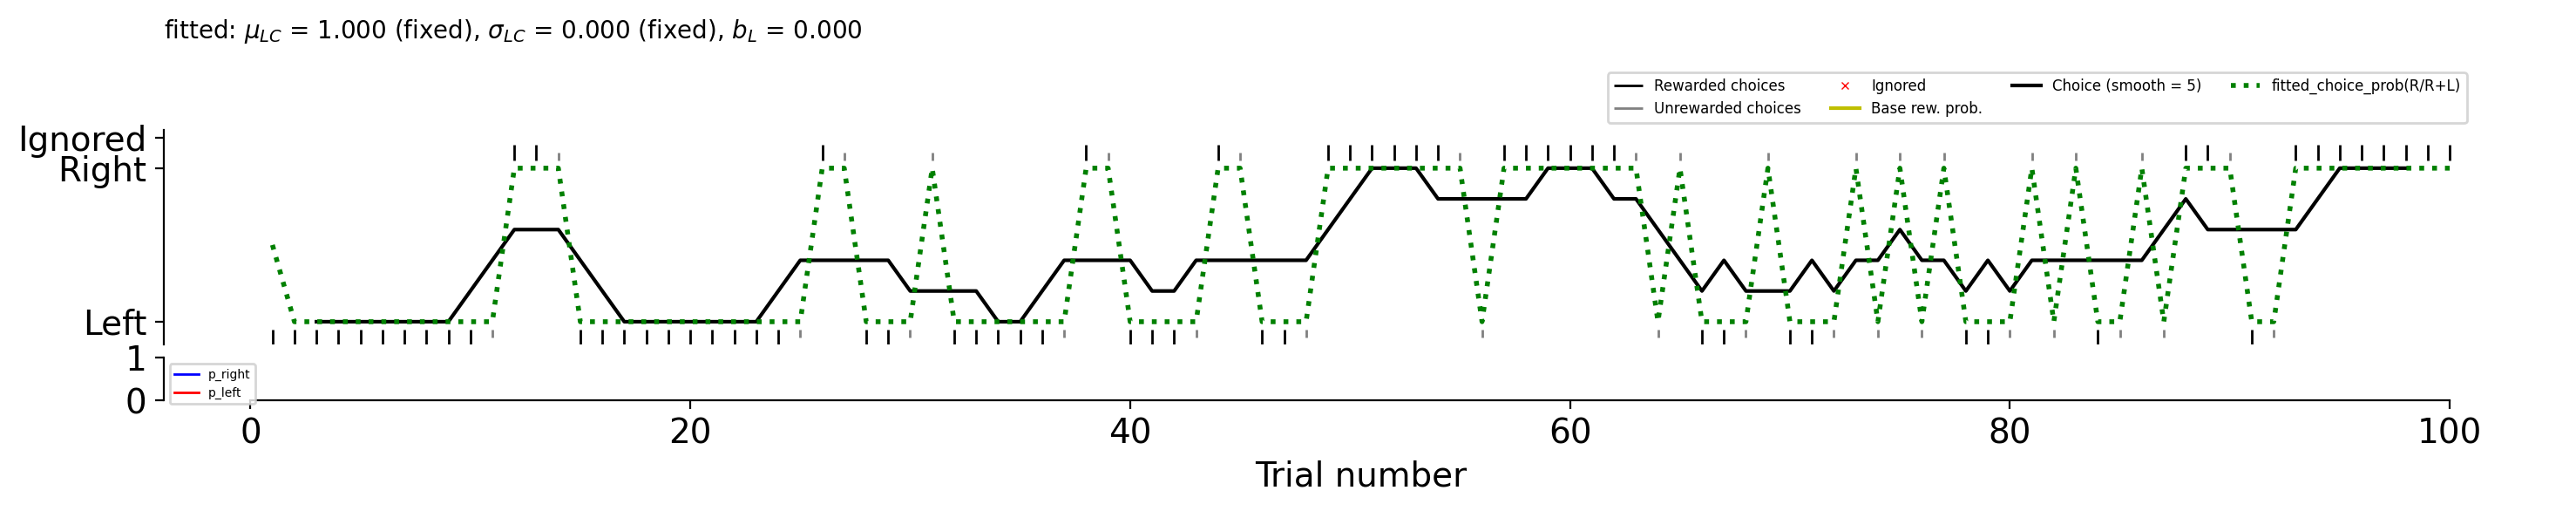

In [23]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

 Another example: RW 1972: 
Shall we add explanation for RW1972 ... I thought RW 1972 is the first model 


## Generating Surrogate Data for Model Validation

This step will allow you to refine the first two steps: confirming that the experimental design elicits the behaviors assumed to be captured by the computational model. To do this, here are some important steps.

1. **Specify the Generative Model**  
   - Choose the model(s) $M_1, M_2, \dots$ you want to test (e.g., Q-learning, Rescorla–Wagner, WSLS).  
   - Decide which latent variables drive behavior (e.g., action values $Q_t$, prediction errors).

2. **Define Parameter Priors / Grids**  
   - For each model, pick realistic parameter ranges or priors:  
     - Learning rate $\alpha \in [0.05, 0.9]$  
     - Inverse temperature $\beta \in [0.5, 10]$  
     - WSLS stay/shift probabilities $p_{\text{stay}}, p_{\text{shift}} \in [0, 1]$  
   - Use either a **grid**, **random uniform**, or **hierarchical prior** sampling scheme.

3. **Simulate Behavioral Data**  
   - For every parameter draw $\boldsymbol{\theta}^{(i)}$:  
     1. Initialize model state (e.g., $Q^k_0 = 0$).  
     2. Loop over trials $t = 1 \dots T$:  
        - Sample choice $c_t \sim p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}^{(i)}, M)$  
        - Sample outcome $r_t$ from the task’s reward schedule  
        - Update model states.  
   - Store trial-wise choices, outcomes, and latent variables.

4. **Compute Diagnostic Summaries**  
   - Reaction-time or choice-probability curves  
   - Learning curves (e.g., moving-window choice of optimal action)  
   - Distribution of prediction errors, switch rates, etc.  
   Use these summaries to confirm the simulated behavior matches the qualitative patterns you expect.

5. **Parameter-Recovery Check**  
   - Fit the same model back to the simulated data.  
   - Correlate recovered parameters $\hat{\boldsymbol{\theta}}$ with the ground-truth $\boldsymbol{\theta}^{(i)}$.  
   - Good recovery (slope ≈ 1, $R^2$ high) indicates your model + fitting procedure can, in principle, retrieve true parameters.

6. **Model-Recovery / Confusability Test**  
   - Fit *all* candidate models to each surrogate dataset.  
   - Evaluate with AIC/BIC or Bayes factors:  
     $$ \text{AIC} = -2\log\hat{L} + 2k,\quad \text{BIC} = -2\log\hat{L} + k\log T. $$  
   - Ideally, the data generated by model $M_i$ is most strongly favored when you fit $M_i$ (diagonal dominance in a confusion matrix).


### Same model type (Loss counting/RW1972), different parameters

Generate multiple LossCounting model with different parameter sets. `fit_para_recovery` is a pre-packed function to do this

<details>
<summary><b> function fit_para_recovery explained </b></summary>

**Overview**
Generate fake data with given parameter and run model fitting to the fake data

**Inputs**
- `forager`: str, Model type identifier: e.g. `LossCounting` or`RW1972_softmax`
- `para_names`: list[str]
- `para_bounds`: list[str]
- `true_paras`: numpy array 
- `fit_method`: str, Optimization algorithm: e.g. `DE` or `L-BFGS-B`

**Outputs**
- `true_paras`:	numpy.ndarray, (n_parameters, n_models), True parameter values used for simulation
- `fitted_paras`:numpy.ndarray, (n_parameters, n_models), Recovered parameter values from fitting

</details>

In [51]:
n_trials = 400
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,2]]
true_paras = generate_true_paras(para_bounds=[[0,0],[30,1]], n_models = 10, method = 'random_uniform')

#visualization of the true parameters
# fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
# axs.plot(true_paras[0,:], true_paras[1,:], 'o')
# axs.set_xlabel('loss_count_threshold_mean')
# axs.set_ylabel('loss_count_threshold_std')
# axs.set_title('True parameters')


8


Parameter Recovery, LossCounting: 100%|██████████| 10/10 [04:26<00:00, 26.70s/it]
/root/capsule/code/utils_model_recovery.py:4902: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(true_paras[para_2d[0],n], true_paras[para_2d[1],n],'ok', markersize=11, fillstyle='none', c = colors[n], label = 'True' if not legend_plotted else '',alpha=.7)
/root/capsule/code/utils_model_recovery.py:4903: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(fitted_paras[para_2d[0],n], fitted_paras[para_2d[1],n],'ok', markersize=7, c = colors[n], label = 'Fitted' if not legend_plotted else '',alpha=.7)


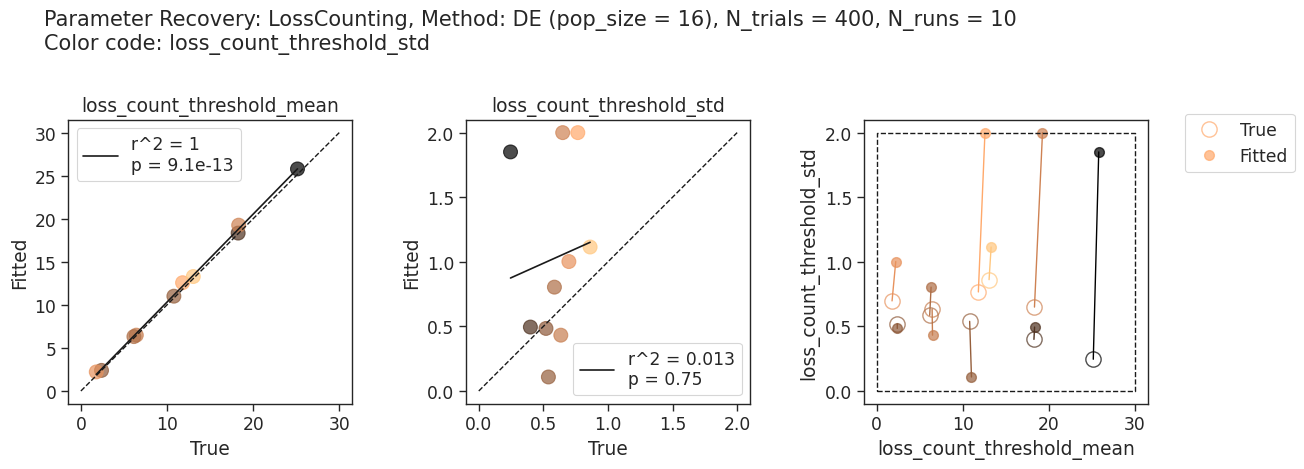

In [52]:
# set the number of workers
n_worker = int(mp.cpu_count()/2)
pool = mp.Pool(processes = n_worker)
print(n_worker)
    
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    

Compute the loss likelihood landscape for different parameter combinations. This can be used to examine how different parameters contribute the behavioral output. 

In [ ]:
n_trials = 300
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,2]]
true_para = [10,1]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool=pool)

#### Another example: RW1972

In [ ]:
n_trials = 300

forager = 'RW1972_softmax'
para_names = ['softmax_temperature','biasL']
para_scales = ['log','linear']
para_bounds = [[1e-2,-10],
               [15, 10]]

n_models = 30
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        np.random.uniform(-5, 5, size = n_models))) # Inspired by Wilson 2019. I found beta ~ Exp(10) would be better
true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,2],[1,2]],
              fit_method = 'DE', pool = pool); 

### Different models
Simulate fake data using `LossCounting`; try to identify the correct model type by fitting through different hypothesis and compare fitting performance


### ▪️ Interpretation of the Plot

- Each **row** corresponds to a candidate model, defined by its parameter set.
- The **ground truth** model in simulation is highlighted (e.g., RW1972).
- **Bars from left to right** show:
  - **Likelihood per trial** (higher = better)
  - **AIC and BIC scores** (lower = better)
  - **Relative log-likelihood**
  - **Model weight** (posterior probability of the model)

✅ Better models are found toward the **right side** of the likelihood plot and the **left side** of the AIC/BIC and log-likelihood plots.

🟦 AIC (blue) and 🟧 BIC (orange) sometimes rank models differently depending on penalty strength.


### ▪️ Summary

By comparing both likelihood and complexity-penalized scores, we can determine:
- Which model best accounts for the data,
- Whether model differences are **decisive** (e.g., by a threshold on log-likelihood or posterior weight),
- And whether more complex models actually yield better predictive power.

📌 **Ground truth** recovery (e.g., identifying RW1972) helps validate the fitting pipeline.



## 3. Model Comparison

Once you’ve fit several models to the same dataset, the next step is to determine which model provides the best explanation of the behavior.

Model comparison helps us:
- Test competing cognitive theories
- Reject overfitting models by penalizing complexity
- Choose models that **generalize** well beyond the current dataset

Common criteria include:
- **Akaike Information Criterion (AIC)**
- **Bayesian Information Criterion (BIC)**
- **Bayes factors**
- **Cross-validated log likelihood**

This step is especially critical when models make similar qualitative predictions but differ quantitatively in how well they explain the data.

> **Examples:** Wilson & Niv, 2011; Daw et al., 2011; Collins & Frank, 2012; Haaf & Rouder, 2017; Donkin et al., 2014.


## Model Comparison

When evaluating which model best explains behavioral data, we compare models not only by how well they fit the data (i.e., likelihood), but also by penalizing model complexity. Two widely used criteria are:

### ▪️ Information Criteria

- **Akaike Information Criterion (AIC)**:
  
  $$
  \text{AIC} = -2 \log \hat{L} + 2k
  $$

- **Bayesian Information Criterion (BIC)**:

  $$
  \text{BIC} = -2 \log \hat{L} + k \log T
  $$

  Where:
  - $\hat{L}$ is the maximum likelihood
  - $k$ is the number of free parameters in the model
  - $T$ is the number of data points (e.g., trials)

- These criteria balance **model fit** with **model complexity**. Lower AIC/BIC values indicate a better model.

### ▪️ Approximate Posterior over Models

The relative probability of a model given the data can be approximated as:

$$
p(M \mid \text{data}) \propto \exp\left(-\frac{\text{IC}}{2}\right)
$$

This allows us to derive:
- **Relative log-likelihood**: $\log_{10} \frac{p(\text{model})}{p(\text{best model})}$
- **Model weights**: normalized probabilities over models

---


In [ ]:
choice_history, reward_history, p_reward = generate_fake_data('LossCounting', ['loss_count_threshold_mean','loss_count_threshold_std'], [10,0])
model_comparison = BanditModelComparison(choice_history, reward_history, p_reward, models = [1,2,5])
model_comparison.fit(pool = pool, plot_predictive=[1,2,3])  # Plot predictive traces for the 1st, 2nd, and 3rd models
model_comparison.show()
model_comparison.plot()

In [57]:
model_comparison.results_sort

,model,Km,AIC,BIC,LPT_AIC,LPT_BIC,LPT,para_names,para_bounds,para_notation,para_fitted,relative_likelihood_AIC,relative_likelihood_BIC,model_weight_AIC,model_weight_BIC,log10_BF_AIC,log10_BF_BIC,best_model_AIC,best_model_BIC
1,LossCounting,2,79.069017,88.886527,0.961275,0.956572,0.963197,"[loss_count_threshold_mean, loss_count_thresho...","[[0, 0], [40, 10]]","$\mu_{LC}$, $\sigma_{LC}$","[9.219, 0.025]",1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-0.000000,-0.000000,1,1
8,Hattori2019,4,544.486023,564.121042,0.761876,0.754441,0.764927,"[learn_rate_rew, learn_rate_unrew, forget_rate...","[[0, 0, 0, 0.01], [1, 1, 1, 15]]","$\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\si...","[1.0, 0.123, 1.0, 0.276]",8.629414e-102,6.369953e-104,8.629414e-102,6.369953e-104,-101.064019,-103.195864,0,0
4,LNP_softmax,4,697.106676,716.741695,0.705954,0.699064,0.708781,"[tau1, tau2, w_tau1, softmax_temperature]","[[0.001, 0.1, 0, 0.01], [15, 40, 1, 15]]","$\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$","[1.761, 1.821, 0.322, 0.091]",6.234873e-135,4.602380e-137,6.234873e-135,4.602380e-137,-134.205172,-136.337018,0,0
7,Bari2019,3,706.434578,721.160842,0.702672,0.697523,0.704782,"[learn_rate, forget_rate, softmax_temperature]","[[0, 0, 0.01], [1, 1, 15]]","$\alpha$, $\delta$, $\sigma$","[0.049, 0.405, 0.01]",5.878945e-137,5.050994e-138,5.878945e-137,5.050994e-138,-136.230701,-137.296623,0,0
5,RW1972_softmax,2,993.920456,1003.737965,0.608679,0.605702,0.609897,"[learn_rate, softmax_temperature]","[[0, 0.01], [1, 15]]","$\alpha$, $\sigma$","[0.967, 0.105]",2.200565e-199,2.200565e-199,2.200565e-199,2.200565e-199,-198.657466,-198.657466,0,0
6,Hattori2019,3,995.517529,1010.243793,0.608194,0.603737,0.610019,"[learn_rate_rew, learn_rate_unrew, softmax_tem...","[[0, 0, 0.01], [1, 1, 15]]","$\alpha_{rew}$, $\alpha_{unr}$, $\sigma$","[0.412, 0.972, 0.047]",9.902258e-200,8.507691e-201,9.902258e-200,8.507691e-201,-199.004266,-200.070188,0,0
3,LNP_softmax,2,999.359351,1009.176861,0.607028,0.604058,0.608242,"[tau1, softmax_temperature]","[[0.001, 0.01], [100, 15]]","$\tau_1$, $\sigma$","[0.001, 0.01]",1.450418e-200,1.450418e-200,1.450418e-200,1.450418e-200,-199.838507,-199.838507,0,0
2,RW1972_epsi,2,1231.991302,1241.808812,0.540435,0.537792,0.541516,"[learn_rate, epsilon]","[[0, 0], [1, 1]]","$\alpha$, $\epsilon$","[0.593, 0.626]",4.426972e-251,4.426972e-251,4.426972e-251,4.426972e-251,-250.353893,-250.353893,0,0


In [58]:
model_comparison.plot_predictive

[1, 2, 3]

In [19]:
for bb in model_comparison.plot_predictive:
    print(bb)
    bb = bb - 1
    if bb < len(model_comparison.results):
        print(bb)
        this_id = model_comparison.results_sort.index[bb] - 1
        this_choice_prob = model_comparison.results_raw[this_id].predictive_choice_prob
        this_result = model_comparison.results_sort.iloc[bb]
        print(this_id, this_choice_prob, this_result)
        ax.plot(np.arange(0, n_trials), this_choice_prob[1,:] , linewidth = max(1.5-0.3*bb,0.2), 
                label = 'Model %g: %s, Km = %g\n%s\n%s' % (bb+1, this_result.model, this_result.Km, 
                                                                                    this_result.para_notation, this_result.para_fitted))


1
0


IndexError: list index out of range

,model,Km,AIC,log10_BF_AIC,model_weight_AIC,BIC,log10_BF_BIC,model_weight_BIC,para_notation,para_fitted
1,LossCounting,2,5.39,-0.00,1.0,15.20,-0.00,1.0,"$\mu_{LC}$, $\sigma_{LC}$","[9.776, 0.026]"
8,Hattori2019,4,493.33,-105.95,0.0,512.96,-108.09,0.0,"$\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\sigma$","[1.0, 0.132, 1.0, 0.264]"
3,LNP_softmax,2,659.56,-142.05,0.0,669.37,-142.05,0.0,"$\tau_1$, $\sigma$","[1.637, 0.091]"
4,LNP_softmax,4,663.56,-142.92,0.0,683.19,-145.05,0.0,"$\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$","[1.637, 2.883, 1.0, 0.091]"
7,Bari2019,3,673.40,-145.06,0.0,688.13,-146.12,0.0,"$\alpha$, $\delta$, $\sigma$","[0.05, 0.424, 0.01]"
5,RW1972_softmax,2,965.27,-208.44,0.0,975.08,-208.44,0.0,"$\alpha$, $\sigma$","[0.96, 0.102]"
6,Hattori2019,3,967.25,-208.87,0.0,981.97,-209.93,0.0,"$\alpha_{rew}$, $\alpha_{unr}$, $\sigma$","[1.0, 0.959, 0.107]"
2,RW1972_epsi,2,1203.89,-260.25,0.0,1213.71,-260.25,0.0,"$\alpha$, $\epsilon$","[0.591, 0.59]"


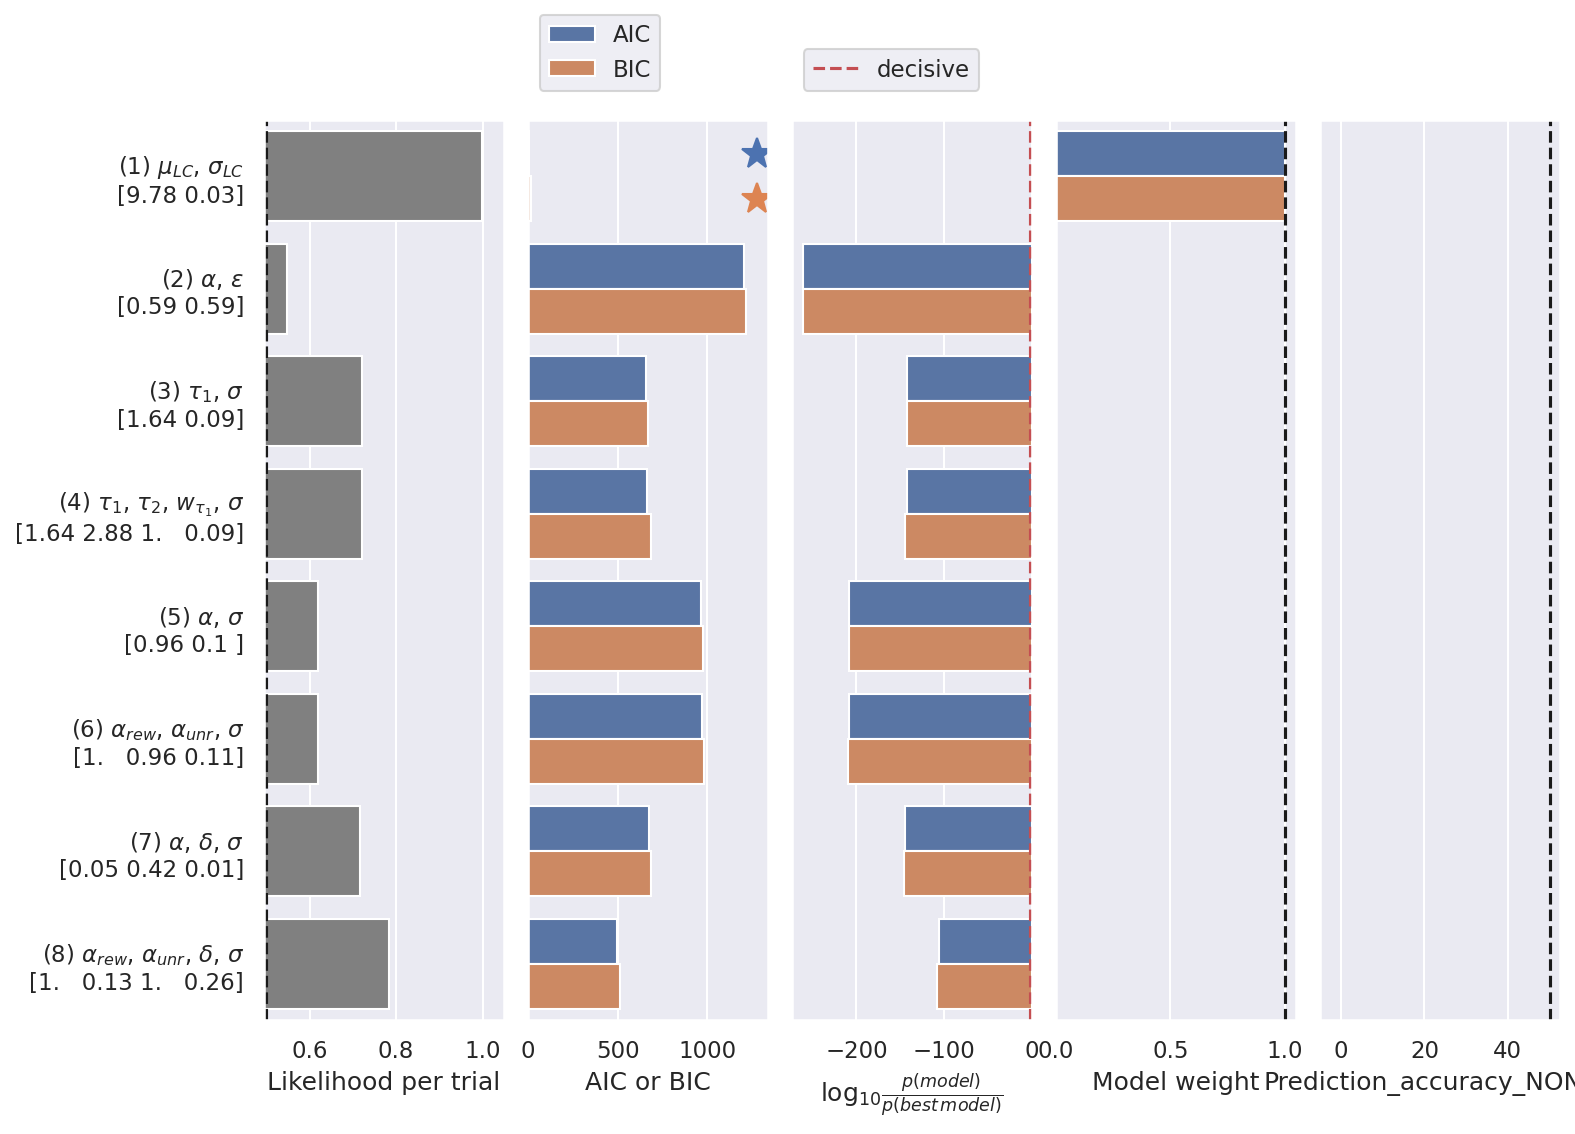

In [23]:
model_comparison.show()
model_comparison.plot()

In [ ]:
choice_history, reward_history, p_reward = generate_fake_data('RW1972_softmax', ['learn_rate','softmax_temperature'], [0.3,0.2])
model_comparison = BanditModelComparison(choice_history, reward_history, p_reward, models = [1,5])
model_comparison.fit(pool = pool, plot_predictive=[1,2,3]) # Plot predictive traces for the 1st, 2nd, and 3rd models
model_comparison.show()
model_comparison.plot()

In [ ]:
model_comparison.show()
model_comparison.plot()

## References

- Wilson, R. C., & Collins, A. G. (2019). Ten simple rules for the computational modeling of behavioral data. *eLife*, 8, e49547. https://doi.org/10.7554/eLife.49547  
- Palminteri, S., Wyart, V., & Koechlin, É. (2017). The importance of falsification in computational cognitive modeling. *Trends in Cognitive Sciences*, 21(6), 425–433. https://doi.org/10.1016/j.tics.2017.03.011
